In [31]:
# Libraries

import sys
import math
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
from datetime import datetime, timedelta
import folium
import webbrowser
import win32com.client as win32
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [32]:
# Inital information

# url without under offer properties
url_wo_uo = 'https://propertylink.estatesgazette.com/commercial-property-for-rent/bath/page-1?filters%5Bnot_property_states%5D%5B%5D=Under+Offer&filters%5Bto_let_price%5D%5Bcurrency%5D=gbp&filters%5Bto_let_price%5D%5Bfrom%5D=&filters%5Bto_let_price%5D%5Bsize_modifier%5D=sqft&filters%5Bto_let_price%5D%5Bto%5D=&search=Bath&sort_direction=desc&sort_field=created_at&view=grid'
# url including under offer properties
url_inc_uo = 'https://propertylink.estatesgazette.com/commercial-property-for-rent/bath/page-1?filters%5Bto_let_price%5D%5Bcurrency%5D=gbp&filters%5Bto_let_price%5D%5Bfrom%5D=&filters%5Bto_let_price%5D%5Bsize_modifier%5D=sqft&filters%5Bto_let_price%5D%5Bto%5D=&search=Bath&sort_direction=desc&sort_field=created_at&view=grid'
html = requests.get(url_inc_uo)
soup = bs(html.text, 'html.parser')

body = soup.find('body')
header = body.find('div', class_ = 'results-header mt-5')
property_count = int(header.find('div', class_ = 'results-message').contents[0].strip())
pages_needed = math.ceil(property_count / 24)
# extra pages only include featured properties - so doesn't go past max. page index.

print(f"There are {property_count} properties on the website currently.\nSo {pages_needed} pages are needed.")

There are 86 properties on the website currently.
So 4 pages are needed.


In [33]:
# Function for getting links

def get_links(soup):
    links = []

    i = 1
    max_iterations = 30
    while len(links) < 24 and i <= max_iterations:
        elements = soup.select(f"body > div.container.mt-3 > div.results.row > div:nth-child({i}) > div.card.h-100.card--results > a")
        # Featured properties still appear elsewhere - so aren't needed. It also causes a break when an empty page is reached.
        # Under offer properties also appear elsewhere or the element path is the same idk.
        # if not elements:
        #     elements = soup.select(f"body > div.container.mt-3 > div.results.row > div:nth-child({i}) > div.card.h-100.card--under-offer > a")

        if not elements:
            i += 1
            continue

        for element in elements:
            href = element['href']
            link = 'https://propertylink.estatesgazette.com'+ href
            links.append(link)
        i += 1

    return links


all_links = get_links(soup)


In [34]:
# Looping through pages

base_url = 'https://propertylink.estatesgazette.com/commercial-property-for-rent/bath/page-{}?filters%5Bnot_property_states%5D%5B%5D=Under+Offer&filters%5Bto_let_price%5D%5Bcurrency%5D=gbp&filters%5Bto_let_price%5D%5Bfrom%5D=&filters%5Bto_let_price%5D%5Bsize_modifier%5D=sqft&filters%5Bto_let_price%5D%5Bto%5D=&search=Bath&sort_direction=desc&sort_field=created_at&view=grid'
# url without under offer properties
url_wo_uo = 'https://propertylink.estatesgazette.com/commercial-property-for-rent/bath/page-{}?filters%5Bnot_property_states%5D%5B%5D=Under+Offer&filters%5Bto_let_price%5D%5Bcurrency%5D=gbp&filters%5Bto_let_price%5D%5Bfrom%5D=&filters%5Bto_let_price%5D%5Bsize_modifier%5D=sqft&filters%5Bto_let_price%5D%5Bto%5D=&search=Bath&sort_direction=desc&sort_field=created_at&view=grid'
# url including under offer properties
url_inc_uo = 'https://propertylink.estatesgazette.com/commercial-property-for-rent/bath/page-{}?filters%5Bto_let_price%5D%5Bcurrency%5D=gbp&filters%5Bto_let_price%5D%5Bfrom%5D=&filters%5Bto_let_price%5D%5Bsize_modifier%5D=sqft&filters%5Bto_let_price%5D%5Bto%5D=&search=Bath&sort_direction=desc&sort_field=created_at&view=grid'

all_links = []  # Store all links from all pages

for page_num in range(1, pages_needed+1):  
    url = url_inc_uo.format(page_num)
    html = requests.get(url)
    soup = bs(html.text, 'html.parser')
    
    page_links = get_links(soup)
    all_links.extend(page_links)  # Add the links from this page to the all_links list

    print(f"Page {page_num} has {len(page_links)} links.")

property_links = list(set(all_links)) # removing duplicates
print(f"Total links collected: {len(property_links)}")


Page 1 has 24 links.
Page 2 has 24 links.
Page 3 has 24 links.
Page 4 has 14 links.
Total links collected: 86


In [35]:
# Single property test

single_link = property_links[4]
single_link = 'https://propertylink.estatesgazette.com/property-details/6987959-suite-5-western-house-2-rush-hill-bath-somerset-ba2-2qh'
print(single_link)

html = requests.get(single_link)
soup = bs(html.text, 'html.parser')

# soup.select('body > div.details-section.details-agent-contacts > div > div > div > div.col-md-4.col-12 > div.agent-name')
agent_name = soup.find('div', class_='agent-name').find_all_next(string=True)[1].strip()


agency_name = soup.select_one('body > div.details-section.details-agent-contacts > div > div > div > div.col-md-4.col-12 > div.agent-logo > img')
if agency_name == None:
    agency_name = soup.select_one('body > div.details-section.details-agent-contacts > div > div > div > div.col-md-4.col-12 > div.agent-logo > a > img')
agency_name = agency_name['alt']

agency_name = soup.find("meta", {"name": "gwa_advertiserName"})
agency_name = agency_name.get("content")



id_tag = soup.find("meta", {"name": "gwa_contentID"})
id_tag = id_tag.get("content")

# address = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(3)') # Full div
# address = address[0].get_text(strip=True) # gives address with below stuck to the front
# address = address.replace("ADDRESS", "").strip() #tidy

address = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > h1')
address = address[0].get_text(strip=True)
address = address.replace("sharebookmark", "").strip() #tidy

size = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(2)')
size = size[0].get_text(strip=True) # gives size with below stuck to the front
size = size.replace("SIZE", "").strip() #tidy

type = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(4)')
type = type[0].get_text(strip=True)
type = type.replace("TYPE", "").strip()

price = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(1)')
price = price[0].get_text(strip=True)
price = price.replace("TO RENT", "").strip()

date_posted = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(6)')
date_posted = date_posted[0].get_text(strip=True)
date_posted = date_posted.replace("POSTED ON", "").strip()

desc = soup.select_one('body > div:nth-of-type(4) > div:nth-of-type(2) > div > div:nth-of-type(5) > div > div:nth-of-type(1)')
desc = desc.get_text(strip=True)

latitude = soup.find('meta', itemprop='latitude')['content']
longitude = soup.find('meta', itemprop='longitude')['content']


try:
    under_offer = soup.select_one('#tab-details > div.results__single-badge.badges.badges--under-offer')
    under_offer = under_offer.get_text(strip=True)
except:
    under_offer = ''

print(f'Agent Name: {agent_name}')
print(f'Agency Name: {agency_name}')
print(f'ID: {id_tag}')
print(f'Address: {address}')
print(f'Size: {size}')
print(f'Type: {type}')
print(f'Price: {price}')
print(f'Date Posted: {date_posted}')
print(f'Description: {desc}\n')
print('Coords: ',latitude, ',', longitude)
print(f'Offer Status: {under_offer}')




https://propertylink.estatesgazette.com/property-details/6987959-suite-5-western-house-2-rush-hill-bath-somerset-ba2-2qh
Agent Name: Maddie Pyles
Agency Name: CSquared (Previously Colston & Colston Chartered Surveyors)
ID: 6987959
Address: Suite 5 Western House, 2 Rush Hill, Bath, Somerset, BA2 2QH
Size: 219 Sq Ft
Type: Office, Offices
Price: £10,200.00  Per  Annum
Date Posted: 1st November 2024
Description: The property comprises well-lit, open plan office space with own kitchen and WC facilities. This office suite is at first floor level and has a private double glazed access via a set of external stairs. The entrance is located to the rear of the main building, via a path to the right-hand side. The unit also benefits from one designated on-site car parking space, and on-street parking available nearby( Agency Pilot Software ref: 907 )

Coords:  51.365498 , -2.394481
Offer Status: 


In [36]:
# Collecting all property information

def assign_value(elements, keyword):
    for element in elements:
        text = element.get_text(strip=True)
        if keyword in text:
            return text.replace(keyword, "").strip()
    return None

property_data = []

for property in property_links:
    # print(property)
    html = requests.get(property)
    soup = bs(html.text, 'html.parser')

    agent_name = soup.find('div', class_='agent-name').find_all_next(string=True)[1].strip()
    
    agency_name = soup.find("meta", {"name": "gwa_advertiserName"})
    agency_name = agency_name.get("content")

    id_tag = soup.find("meta", {"name": "gwa_contentID"})
    id_tag = id_tag.get("content")

    desc = soup.select_one('body > div:nth-of-type(4) > div:nth-of-type(2) > div > div:nth-of-type(5) > div > div:nth-of-type(1)')
    desc = desc.get_text(strip=True)

    # address = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > h1')
    # address = address[0].get_text(strip=True)
    # address = address.replace("sharebookmark", "").strip() #tidy

    elements = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div')

    # Assign values based on keywords - thank you ChatGPT for this one...
    price = assign_value(elements, "TO RENT")
    size = assign_value(elements, "SIZE")
    address = assign_value(elements, "ADDRESS")
    type = assign_value(elements, "TYPE")
    # tenure = assign_value(elements, "TENURE")
    date_posted = assign_value(elements, "POSTED ON")

    latitude = soup.find('meta', itemprop='latitude')['content']
    longitude = soup.find('meta', itemprop='longitude')['content']

    try:
        under_offer = soup.select_one('#tab-details > div.results__single-badge.badges.badges--under-offer')
        under_offer = under_offer.get_text(strip=True)
    except:
        under_offer = ''
    

    property_data.append({
        'Id': id_tag,
        'Offer Status': under_offer,
        'Address': address,
        'Price': price,
        'Size': size,
        'Property Type': type,
        'Agency Name': agency_name,
        'Agent Name': agent_name,
        'Description': desc,
        'Property Link': property,
        'Date Posted': date_posted,
        'Latitude': latitude,
        'Longitude': longitude
    })

    

df = pd.DataFrame(property_data)



df.head()

,Id,Offer Status,Address,Price,Size,Property Type,Agency Name,Agent Name,Description,Property Link,Date Posted,Latitude,Longitude
0,6960247,,"25 Queen Square, Bath, Bath And North East Som...",ROA,"627 - 4,150 Sq Ft","Office, Offices",CSquared (Previously Colston & Colston Charter...,Emily Dagg,DescriptionThe property comprises office suite...,https://propertylink.estatesgazette.com/proper...,8th August 2024,51.3839494,-2.3636339
1,6980582,Under Offer,"Lower Ground Floor , 8 Belmont, Bath, Bath and...","£8,000.00 Per Annum",587 Sq Ft,"Office, Offices",CSquared (Previously Colston & Colston Charter...,Maddie Pyles,The lower ground floor comprises two office ro...,https://propertylink.estatesgazette.com/proper...,17th January 2025,51.3865468,-2.3610965
2,7001217,Under Offer,"11and11A Queen Street, Bath, Bath and North Ea...","£22,500.00 Per Annum",0 - 980 Sq Ft,"General Retail, Retail",Carter Jonas LLP,Tim Brooksbank,"Grade II Listed, mid terrace property comprise...",https://propertylink.estatesgazette.com/proper...,4th February 2025,51.382705,-2.361986
3,6985747,Under Offer,"3 Northumberland Buildings, Bath, Bath and Nor...","£20,000.00 Per Annum","1,161 Sq Ft","Office, Retail - High Street, Offices, Retail",CSquared (Previously Colston & Colston Charter...,Maddie Pyles,3 Northumberland Buildings comprises the groun...,https://propertylink.estatesgazette.com/proper...,28th November 2024,51.383127,-2.36232
4,6923560,,"Upper Floors , 39 Gay Street, Bath, Bath And N...","£10,000.00 - £23,500.00 Per Annum",436 Sq Ft,"Office, Offices",CSquared (Previously Colston & Colston Charter...,Maddie Pyles,Gay Street is part of Bath's long standing eco...,https://propertylink.estatesgazette.com/proper...,12th August 2024,51.3841127,-2.3631466


In [37]:
# Writing to csv

today = datetime.now()
last_week = today - timedelta(weeks=1)
today = today.strftime("%d.%m.%y")
last_week = last_week.strftime("%d.%m.%y")
df.to_csv(f'EG_scraped_{today}.csv', index=False, sep=',', encoding='utf-8-sig', header=True, quotechar='"')
# df.to_csv(f'EG_underoffers_{today}.csv', index=False, sep=',', encoding='utf-8-sig', header=True, quotechar='"')

In [1]:
# Comparison w/ last week & writing changes to xlsx


today = datetime.now()
last_week = today - timedelta(weeks=1)
today = today.strftime("%d.%m.%y")
last_week = last_week.strftime("%d.%m.%y")
print(today)
df_old = pd.read_csv(f'EG_scraped_{last_week}.csv')
# df_old = pd.read_csv(f'EG_scraped_16.12.24.csv')
df_new = pd.read_csv(f'EG_scraped_{today}.csv')
# df_new = pd.read_csv(f'EG_scraped_06.01.25.csv')

df_old.head()

key = 'Id'
df_dropped = df_old[~df_old[key].isin(df_new[key])]
# df_dropped.head()
# df_dropped.to_csv('dropped_5.11.24.csv', index=False)

df_posted = df_new[~df_new[key].isin(df_old[key])]
# df_posted.info()
# df_posted.head()
# df_posted.to_csv('posted_5.11.24.csv', index=False)



df_posted['Website Status'] = 'Added'
df_dropped['Website Status'] = 'Dropped'

df_posted['Offer Status'] = ''
df_dropped['Offer Status'] = ''

df_common = pd.merge(df_old[['Id','Offer Status']], df_new, on=key, suffixes=('_old', '_new'))
df_common.head()

rows_to_include = []
df_common['Offer Status'] = ''

for index, row in df_common.iterrows():
    print(f"Processing row {index}: Offer Status_new = {row['Offer Status_new']}, Offer Status_old = {row['Offer Status_old']}")
    
    if row['Offer Status_new'] == row['Offer Status_old'] or (pd.isna(row['Offer Status_new']) and pd.isna(row['Offer Status_old'])):
        # print("No change in offer status.")
        continue
    elif row['Offer Status_new'] == 'Under Offer' and row['Offer Status_old'] != 'Under Offer':
        df_common.loc[index, 'Offer Status'] = 'Now under offer'  # Updated here
        rows_to_include.append(df_common.loc[index].to_dict())
        print("Updated to 'Now under offer'")
    elif row['Offer Status_new'] != 'Under Offer' and row['Offer Status_old'] == 'Under Offer':
        df_common.loc[index, 'Offer Status'] = 'Previously under offer'  # Updated here
        rows_to_include.append(df_common.loc[index].to_dict())
        print("Updated to 'Was under offer'")
    else:
        print(f"Row {index}: Offer Status_new = {row['Offer Status_new']}, Offer Status_old = {row['Offer Status_old']}")
        print('Unknown outcome')

# Display the updated DataFrame
print(df_common)
    

df_offers = pd.DataFrame(rows_to_include)
df_offers['Website Status'] = 'Updated'
df_changes = pd.concat([df_posted, df_dropped, df_offers], ignore_index=True)
# df_changes = df_changes[['Website Status'] + [ col for col in df_changes.columns if col != 'Website Status' ]] # changes column order
web_status = df_changes.pop('Website Status')
df_changes.insert(1, 'Website Status', web_status)

emails = pd.read_csv('../emails.csv')
emails['Agent Name'] = emails['Forename'] + ' ' + emails['Surname']
df_changes = pd.merge(df_changes, emails[['Agent Name', 'Email']], on='Agent Name', how='left')

print(f"\n\n\n {df_common.iloc[0]}")
print(df_changes.info())
df_changes.head()
df_changes.drop(['Offer Status_old','Offer Status_new'], axis=1, inplace=True)
# for rows in df_changes.iterrows():
#     if rows['Offer Status_new'] ==

df_changes.to_csv(f'changes_{today}.csv', index=False)
df_changes.to_excel(f'EGPL_changes_{today}.xlsx', index=False, engine='openpyxl')
# Changes fine up to here - I think

NameError: name 'datetime' is not defined

In [39]:
#Splitting Names into first and last + merge w/ emails

df_changes['Agent Name']
df_changes[['First Name', 'Last Name']] = df_changes['Agent Name'].str.split(' ', n=1, expand=True)
df_changes.head()

,Id,Website Status,Offer Status,Address,Price,Size,Property Type,Agency Name,Agent Name,Description,Property Link,Date Posted,Latitude,Longitude,Offer Status_old,Offer Status_new,Email,First Name,Last Name
0,7018354,Added,,"8a High Street, Weston, Bath, Somerset, BA1 4B...",£700.00 Per Month,650 Sq Ft,"Retail - High Street, Retail",The Online Letting Agents,The Online Letting Agents,"Retail shop located in Weston village, Bath2 R...",https://propertylink.estatesgazette.com/proper...,19th February 2025,51.395598,-2.39013,NaN,NaN,NaN,The,Online Letting Agents
1,6976464,Updated,Now under offer,"1 Cleveland Place East, Bath, Bath and North E...","£18,000.00 Per Annum",852 Sq Ft,"Retail - High Street, Restaurants/Cafes, Retai...",CSquared (Previously Colston & Colston Charter...,Maddie Pyles,The shop sits within a Grade II Listed propert...,https://propertylink.estatesgazette.com/proper...,20th February 2025,51.390158,-2.35621,NaN,Under Offer,maddie.pyles@cs-re.co.uk,Maddie,Pyles


In [40]:
# Making the map of all instructions

df = pd.read_csv(f'EG_scraped_{today}.csv')

# Ensure the 'Description' column has no NaN values and is treated as strings
df['Description'] = df['Description'].fillna('').astype(str)

# map = folium.Map(location=(51.38, -2.36), zoom_start=50, width="50%", height="50%")
# location - the center of the map, zoom_start - the resolution
x = 0
y = 0

for index, row in df.iterrows():
    popup_content = f"""
    <b>Id:</b> {row.get('Id', 'N/A')}<br>
    <b>Address:</b> {row.get('Address', 'N/A')}<br>
    <b>Price:</b> {row.get('Price', 'N/A')}<br>
    <b>Size:</b> {row.get('Size', 'N/A')}<br>
    <b>Property Type:</b> {row.get('Property Type', 'N/A')}<br>
    <b>Agency Name:</b> {row.get('Agency Name', 'N/A')}<br>
    <b>Agent Name:</b> {row.get('Agent Name', 'N/A')}<br>
    <b>Description:</b> {row['Description'][:200]}...<br>
    <b>Property Link:</b> <a href="{row.get('Property Link', '#')}" target="_blank">Link</a><br>
    <b>Date Posted:</b> {row.get('Date Posted', 'N/A')}
    """

    if row['Agency Name'].lower().find('csquared') != -1:  # Check for CSquared
        colour = '#E7482A'  # CSquared orange
        y += 1
    else:
        colour = 'darkblue'  # #212C52 is the colour I want, but can't get it to work - apparently folium icons don't work well with Hex codes consistently

    x += 1
    folium.Marker(
        location=(row.get('Latitude', 0), row.get('Longitude', 0)),
        popup=folium.Popup(popup_content, max_width=1000),
        icon=folium.Icon(color=colour)
    ).add_to(map)

df = pd.read_csv(f'EG_scraped_{today}.csv')

# Ensure the 'Description' column has no NaN values and is treated as strings
df['Description'] = df['Description'].fillna('').astype(str)

map = folium.Map(location=(51.38, -2.36), zoom_start=10)  # location - the center of the map, zoom_start - the resolution
x = 0

for index, row in df.iterrows():
    popup_content = f"""
    <b>Id:</b> {row.get('Id', 'N/A')}<br>
    <b>Address:</b> {row.get('Address', 'N/A')}<br>
    <b>Price:</b> {row.get('Price', 'N/A')}<br>
    <b>Size:</b> {row.get('Size', 'N/A')}<br>
    <b>Property Type:</b> {row.get('Property Type', 'N/A')}<br>
    <b>Agency Name:</b> {row.get('Agency Name', 'N/A')}<br>
    <b>Agent Name:</b> {row.get('Agent Name', 'N/A')}<br>
    <b>Description:</b> {row['Description'][:200]}...<br>
    <b>Property Link:</b> <a href="{row.get('Property Link', '#')}" target="_blank">Link</a><br>
    <b>Date Posted:</b> {row.get('Date Posted', 'N/A')}
    """

    if row['Agency Name'].lower().find('csquared') != -1:  # Check for CSquared
        colour = '#E7482A'  # CSquared orange
    else:
        colour = 'darkblue'  # #212C52 is the colour I want, but can't get it to work - apparently folium icons don't work well with Hex codes consistently

    x += 1
    folium.Marker(
        location=(row.get('Latitude', 0), row.get('Longitude', 0)),
        popup=folium.Popup(popup_content, max_width=1000),
        icon=folium.Icon(color=colour)
    ).add_to(map)

print(f'There are {x} properties for commerical rent in Bristol, {y} of which are under CSquared instruction. That is {round(100 * y/x, 2)}%')

map

There are 86 properties for commerical rent in Bristol, 40 of which are under CSquared instruction. That is 46.51%


C:\Users\GuyAnderson\AppData\Local\Temp\ipykernel_11616\2580071349.py:37: UserWarning: color argument of Icon should be one of: {'darkpurple', 'white', 'beige', 'purple', 'gray', 'lightblue', 'lightgreen', 'green', 'pink', 'lightred', 'orange', 'red', 'blue', 'black', 'darkred', 'lightgray', 'darkgreen', 'darkblue', 'cadetblue'}.
  icon=folium.Icon(color=colour)
C:\Users\GuyAnderson\AppData\Local\Temp\ipykernel_11616\2580071349.py:71: UserWarning: color argument of Icon should be one of: {'darkpurple', 'white', 'beige', 'purple', 'gray', 'lightblue', 'lightgreen', 'green', 'pink', 'lightred', 'orange', 'red', 'blue', 'black', 'darkred', 'lightgray', 'darkgreen', 'darkblue', 'cadetblue'}.
  icon=folium.Icon(color=colour)


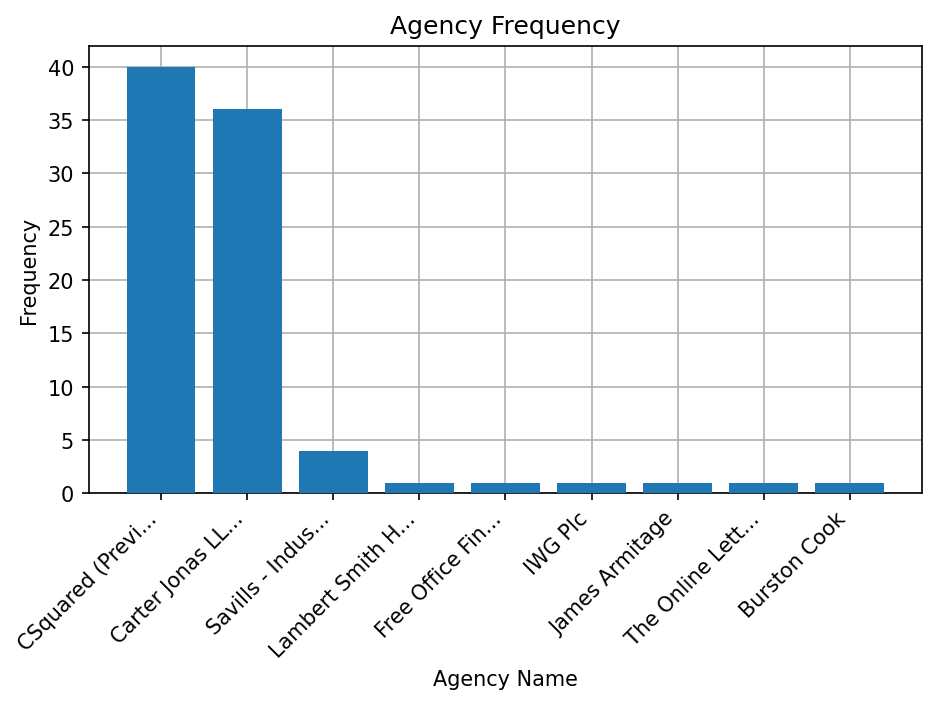

In [41]:
# Plotting bar graph by agency

import matplotlib.pyplot as plt

max_length = 15  # Adjust this value as needed

# Count occurrences of each unique category in 'Agency Name'
counts = df['Agency Name'].value_counts()

# Count occurrences of each unique category in 'Agency Name'
categories = df['Agency Name'].value_counts().index  # Unique categories
values = df['Agency Name'].value_counts().values     # Corresponding counts


categories = [name[:max_length] + '...' if len(name) > max_length else name for name in counts.index]
# Create a bar chart
plt.bar(categories, values, zorder=3)

# Add title and labels
plt.title('Agency Frequency')
plt.xlabel('Agency Name')
plt.ylabel('Frequency')
plt.grid(True, zorder=0)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [42]:
# Email draft - only if dropped - ACTUALLY DOES MAILTO NOW

for index in df_changes.index:
    if df_changes.loc[index, 'Website Status'] == 'Dropped':
# pd.set_option('display.max_colwidth', None)
        pd.set_option('display.max_colwidth', 100)

        email_body = f"""Hi {df_changes.iloc[index]['First Name']},\n 
I see that {df_changes.iloc[index]['Address']} has been taken off the wesbites. Please could you let me know the tenant, rent and lease length?\n
Thanks,\n [INSERT SIGNATURE]\n"""
        # text like this doesnt need to be indented for some reason.

        my_email = ''
        my_password = ''
        if not pd.isna(df_changes.iloc[index]['Email']):
            email_address = df_changes.iloc[index]['Email']
            # print(f'mailto:{email_address}')

            address = df_changes.iloc[index]['Address']
            subject = address[:30] + '...' 

            body = email_body.replace(' ', '%20').replace('\n','%0A')

            # webbrowser.open('mailto:?to=' + email_address + '&subject=' + subject + '&body=' + body, new=1)
        # Line above doesn't do anything (as far as I can tell) if email_address variable is empty. Result - I thought it might break it.
        else:
            print('No email address found.')
        
        # print(email_body)

print(f"\n\n\n {df_changes.iloc[-1]}")



# Email to Both Emilys, MAddie, Allan, Nathan & Rupert!!





 Id                                                            6976464
Website Status                                                Updated
Offer Status                                          Now under offer
Address             1 Cleveland Place East, Bath, Bath and North E...
Price                                          £18,000.00  Per  Annum
Size                                                        852 Sq Ft
Property Type       Retail - High Street, Restaurants/Cafes, Retai...
Agency Name         CSquared (Previously Colston & Colston Charter...
Agent Name                                               Maddie Pyles
Description         The shop sits within a Grade II Listed propert...
Property Link       https://propertylink.estatesgazette.com/proper...
Date Posted                                        20th February 2025
Latitude                                                    51.390158
Longitude                                                    -2.35621
Offer Status_old

In [43]:
# Alternative method for emails - main method in box above

# outlook = win32.Dispatch('outlook.application')
# mail = outlook.CreateItem(0)

# # Set email parameters
# mail.To = email_address
# mail.Subject = subject
# mail.Body = email_body

# # mail.Display(True)